In [70]:
import numpy as np
import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline
from astroML import time_series
import supersmoother

import hypra.prot.fix_kepler
import hypra.prot.time_series

from k2spin import lc
from k2spin import k2io
from k2spin import plot

Now I have corrected lightcurves, no need to constantly re-run this

In [24]:
#filename = "output_lcs/ktwo210359769-c04_lcs.csv"
filename = "output_lcs/ktwo210365286-c04_lcs.csv"
#filename = "output_lcs/ktwo210408563-c04_lcs.csv"
lcs = at.read(filename, names=["t","raw","det","corr","sec"])

t = lcs["t"]
y = lcs["corr"]
dy = np.ones_like(y)

print len(t)
print len(t)/400
print 400.0/len(t)

2953
7
0.135455469015


Test the Edelson-Krolik modified ACF on the raw lightcurve

In [25]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,70,1000)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

(0, 20)

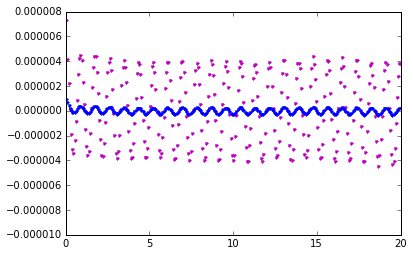

In [69]:
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Gaussian1DKernel
# smooth the ACF
gauss_kernel = Gaussian1DKernel(18,x_size=9)
sm_acf = ap_convolve(C_EK, gauss_kernel,boundary="extend")
plt.plot(t_EK, C_EK, "m.")
plt.plot(t_EK, sm_acf, "b.")
plt.xlim(0, 20)

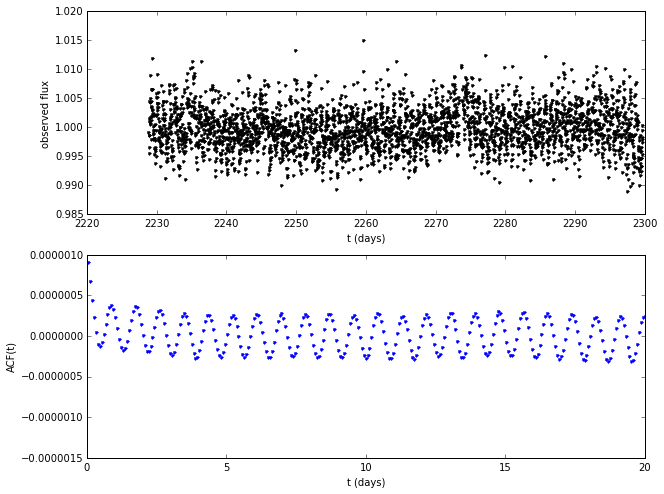

In [66]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, sm_acf, 'b.', lw=1)
ax.set_xlim(0, 20)
#ax.set_ylim(-0.003, 0.003)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

0.875875875876
1.71671671672


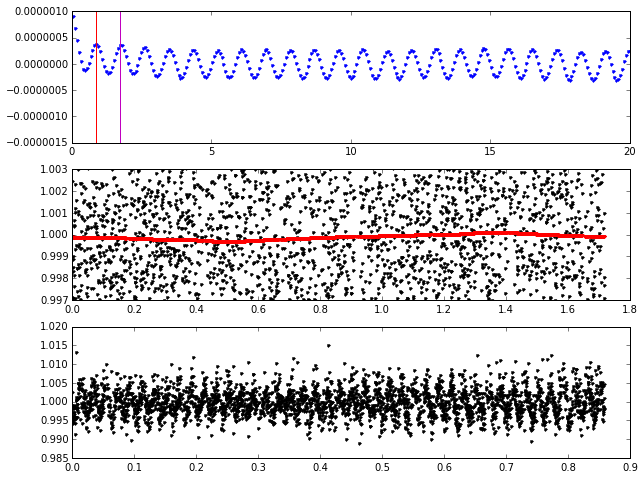

In [85]:
reload(hypra.prot.time_series)
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(311)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, sm_acf, 'b.', lw=1)
ax.set_xlim(0, 20)
#ax.set_ylim(-0.003, 0.003)
subc = np.where((t_EK>0.5) & (t_EK<20))[0]
firstpeak = subc[np.argmax(sm_acf[subc])]
ax.axvline(t_EK[firstpeak], color="r")
fp = t_EK[firstpeak]
print fp

fp2 = hypra.prot.time_series.find_prot(t_EK, sm_acf)
ax.axvline(fp2, color="m")
print fp2

ax = fig.add_subplot(312)
phased_t = t % fp2
ax.plot(phased_t, y, 'k.')

model = supersmoother.SuperSmoother(period=fp2, alpha=10)
y_t = model.fit(t, y).predict(t)
y_phase = model.fit(phased_t, y).predict(phased_t)
ax.plot(phased_t, y_t, 'r.')
ax.set_ylim(0.997,1.003)

ax = fig.add_subplot(313)
phased_t = t % (fp2 / 2.0)
ax.plot(phased_t, y, 'k.')


That _looks_ nice, but that's a teeny tiny value for the ACF and I have no idea what the errors look like this time

Now try it with the flux that's been position-corrected

What about filling the gaps?

In [29]:
cadence = np.median(np.diff(t))
print cadence

0.0204319999998


1.6958559999834506

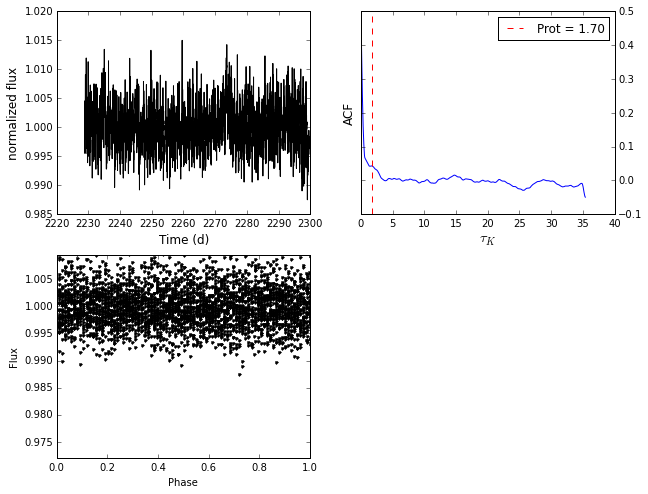

In [30]:
t2, y2, dy2 = hypra.prot.fix_kepler.fill_gaps(t,y,dy)
hypra.prot.time_series.run_acf(t2, y2, plot=True)

So it looks nice when applied to the corrected lc....

Let's try the raw lightcurve

1.7162879999832512

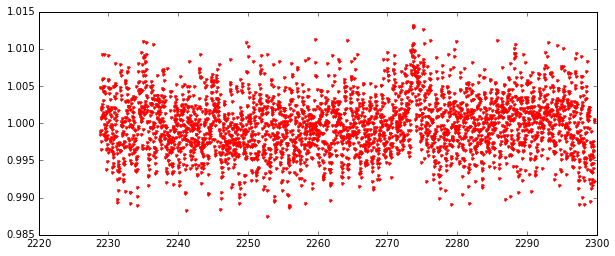

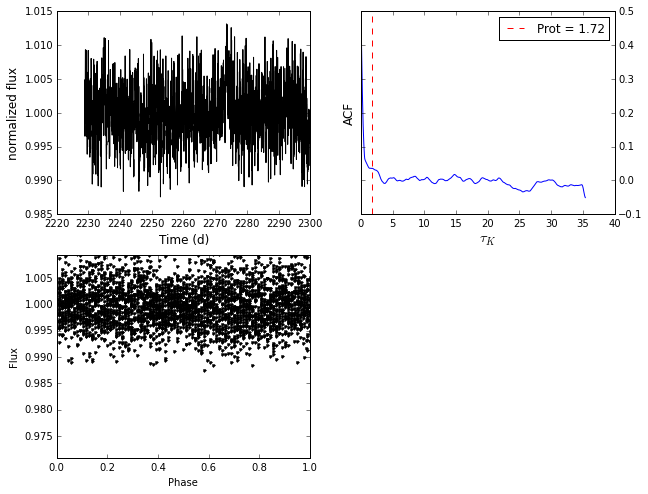

In [39]:
t3, y3, dy3 = hypra.prot.fix_kepler.fill_gaps(t, lcs["det"], dy)
plt.figure(figsize=(10,4))
plt.plot(t3,y3,'r.')
hypra.prot.time_series.run_acf(t3, y3, plot=True)